In [2]:
# import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)
# %matplotlib widget

%run ./scripts/util_func.py

In [3]:
# import data to dataframe

data = pd.read_csv("/home/dominic/Documents/publications/sensors2021/offline_model_training/powertrain_dynamics_IPEM/data/data_imu_jacked.csv") 

array_start_cut = 6700

data = data.iloc[array_start_cut:]

print(data)

       Unnamed: 0      ros_time  wheel_meas_index  cmd_right_vel  \
6700         6700  1.604065e+18             143.0      -8.826112   
6701         6701  1.604065e+18             143.0      -8.596224   
6702         6702  1.604065e+18             143.0      -8.596224   
6703         6703  1.604065e+18             143.0      -8.596224   
6704         6704  1.604065e+18             143.0      -8.596224   
...           ...           ...               ...            ...   
11884       11884  1.604065e+18             219.0       0.000000   
11885       11885  1.604065e+18             219.0       0.000000   
11886       11886  1.604065e+18             219.0       0.000000   
11887       11887  1.604065e+18             219.0       0.000000   
11888       11888  1.604065e+18             219.0       0.000000   

       meas_right_vel  js_right_vel   imu_vel  
6700        -8.949176     -9.402961 -9.027137  
6701        -8.949176     -9.402961 -8.983751  
6702        -8.949176     -9.402961 -8.

In [4]:
# convert dataframe to numpy array

array = data.to_numpy()
array =np.delete(array,[0],axis=0)

time_arr = array[:,1]
time_arr = (time_arr - time_arr[0]) * 10**(-9)
meas_index_arr = array[:,2]

left_vel_cmd_arr = array[:,3]
left_vel_meas_arr = array[:,4]
left_vel_js_arr = array[:,5]
imu_arr = array[:,6]

print(time_arr)


[0.00000000e+00 1.00001280e-02 1.99731200e-02 ... 5.18500582e+01
 5.18600340e+01 5.18699973e+01]


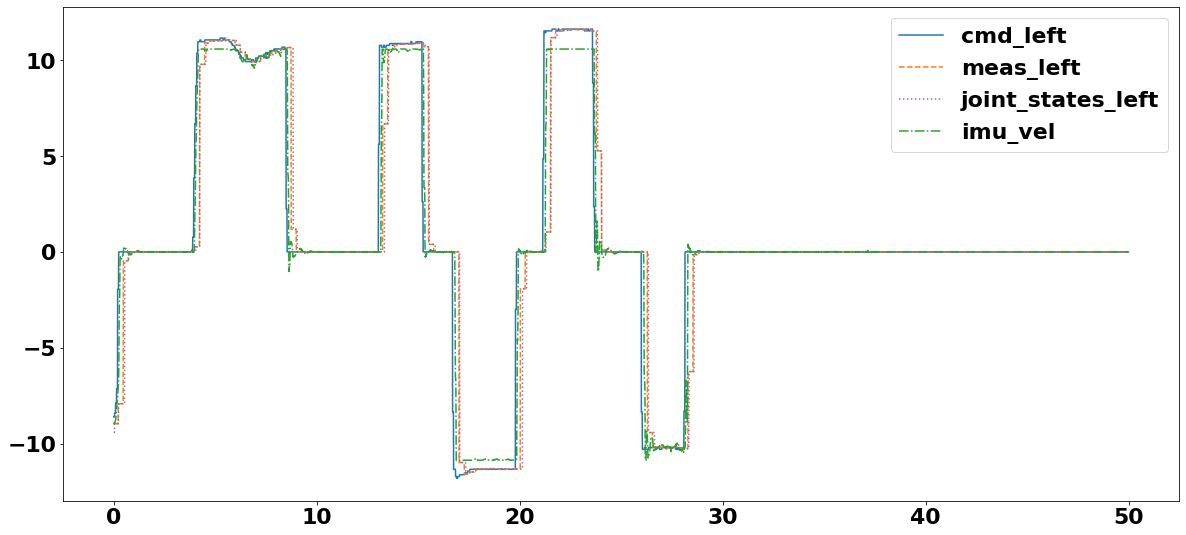

In [8]:
# plot commanded and measured wheel velocities
slice_start = 1
slice_end = 5000

# %matplotlib widget

plt.figure(1, figsize=(20,20))
plt.subplot(211)
plt.plot(time_arr[slice_start:slice_end], left_vel_cmd_arr[slice_start:slice_end], c='tab:blue', label='cmd_left')
plt.plot(time_arr[slice_start:slice_end], left_vel_meas_arr[slice_start:slice_end], c='tab:orange', linestyle='dashed', label='meas_left')
plt.plot(time_arr[slice_start:slice_end], left_vel_js_arr[slice_start:slice_end], c='tab:purple', linestyle='dotted', label='joint_states_left')
plt.plot(time_arr[slice_start:slice_end], imu_arr[slice_start:slice_end], c='tab:green', linestyle='dashdot', label='imu_vel')
plt.legend()

plt.show()

In [28]:
# Run model on all data

# init tau_c and tau_d values

tau_c = 0.02
tau_d = 0.1

left_model_vel = np.zeros((meas_index_arr.shape[0]))

for i in range(10, meas_index_arr.shape[0]-1):
    
    dt = (time_arr[i] - time_arr[i-1])
    left_model_vel[i+1] = powerTrain_vel(tau_c, tau_d, left_vel_cmd_arr, left_model_vel, i, dt)
    


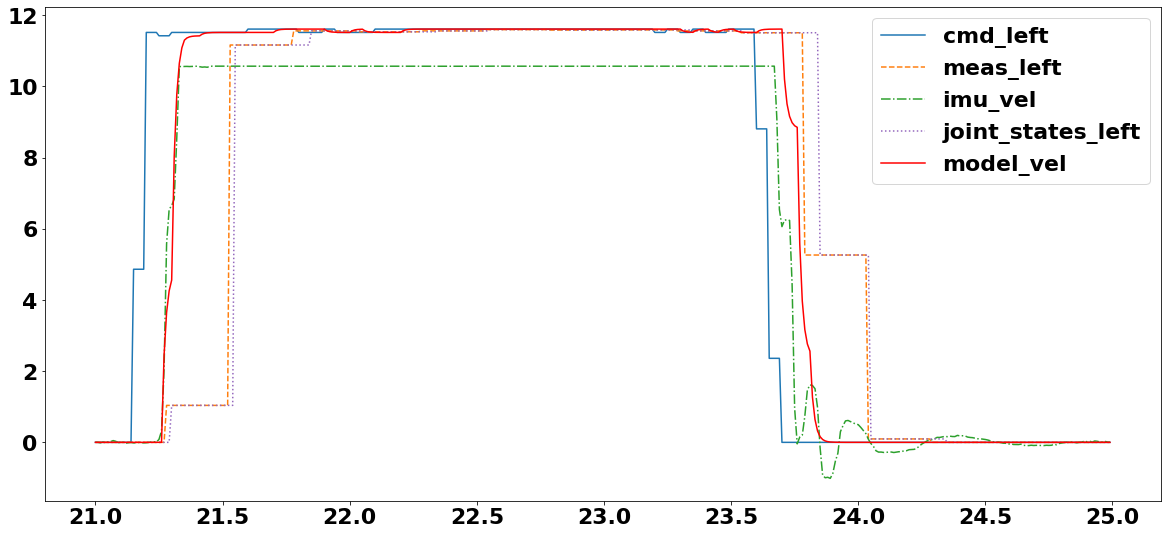

In [29]:
# plot commanded and measured wheel velocities
# slice_start = 1
# slice_end = time_arr.shape[0]

plt.figure(2, figsize=(20,20))
plt.subplot(211)
plt.plot(time_arr[slice_start:slice_end], left_vel_cmd_arr[slice_start:slice_end], c='tab:blue', label='cmd_left')
plt.plot(time_arr[slice_start:slice_end], left_vel_meas_arr[slice_start:slice_end], c='tab:orange', linestyle='dashed', label='meas_left')
plt.plot(time_arr[slice_start:slice_end], imu_arr[slice_start:slice_end], c='tab:green', linestyle='dashdot', label='imu_vel')
plt.plot(time_arr[slice_start:slice_end], left_vel_js_arr[slice_start:slice_end], c='tab:purple', linestyle='dotted', label='joint_states_left')
plt.plot(time_arr[slice_start:slice_end], left_model_vel[slice_start:slice_end], c='red', linestyle='solid', label='model_vel')
plt.legend()

plt.show()

In [16]:
# Run EKF for model parameters (imu)

tau_c = 0.1
tau_d = 0.05

left_EKF_mod_vel_imu = np.zeros((meas_index_arr.shape[0]))
left_EKF_vel = np.zeros((meas_index_arr.shape[0]))
#right_model_vel = np.zeros((meas_index_arr.shape[0]))
pred_start = 0

d_tau_c = 0.01
tau_c_add = tau_c + d_tau_c
tau_c_sub = tau_c - d_tau_c

d_tau_d = 0.01
tau_d_add = tau_d + d_tau_d
tau_d_sub = tau_d - d_tau_d

vel_tau_c_add = 0
vel_tau_c_sub = 0

vel_tau_d_add = 0
vel_tau_d_sub = 0

d_left_vel_cmd = 0.01
left_vel_cmd_add_arr = left_vel_cmd_arr + d_left_vel_cmd
left_vel_cmd_sub_arr = left_vel_cmd_arr - d_left_vel_cmd

P = np.array([[0.05, 0.0], [0.0, 0.05]])
trans_mat = np.array([[0.0,0.0], [0.0, 0.0]])
Cv = np.array([[0.05, 0.0], [0.0, 0.05]])

meas_jac = np.array([0.0, 0.0])
Cw = 1000.0

tau_arr = np.zeros((imu_arr.shape[0], 2))
tau_arr[0,0] = tau_c
tau_arr[0,1] = tau_d

I_2 = np.eye(2,2)


for i in range(1, time_arr.shape[0]-1): 
    dt = time_arr[i] - time_arr[i-1]
    
    left_EKF_vel[i+1] =  powerTrain_vel(tau_c, tau_d, left_vel_cmd_arr, imu_arr, i, dt)
    
    vel_tau_c_add = powerTrain_vel(tau_c_add, tau_d, left_vel_cmd_arr, imu_arr, i, dt)
    vel_tau_c_sub = powerTrain_vel(tau_c_sub, tau_d, left_vel_cmd_arr, imu_arr, i, dt)
    
    vel_tau_d_add = powerTrain_vel(tau_c, tau_d_add, left_vel_cmd_arr, imu_arr, i, dt)
    vel_tau_d_sub = powerTrain_vel(tau_c, tau_d_sub, left_vel_cmd_arr, imu_arr, i, dt)
    
    left_vel_cmd_add = powerTrain_vel(tau_c, tau_d, left_vel_cmd_add_arr, imu_arr, i, dt)
    left_vel_cmd_sub = powerTrain_vel(tau_c, tau_d, left_vel_cmd_sub_arr, imu_arr, i, dt)
    
    meas_jac[0] = central_diff(vel_tau_c_add, vel_tau_c_sub, d_tau_c)
    meas_jac[1] = central_diff(vel_tau_d_add, vel_tau_d_sub, d_tau_d)
    comm_jac = central_diff(left_vel_cmd_add, left_vel_cmd_sub, d_left_vel_cmd)
    
    P = trans_mat @ P @ trans_mat.T + comm_jac ** 2 * Cv
    innov = imu_arr[i+1] - left_EKF_vel[i+1]
    K_gain = P @ meas_jac.T * (meas_jac @ P @ meas_jac.T + Cw) ** (-1)
    tau_arr[i, :] = tau_arr[i-1,:] + K_gain * innov

    P = (I_2 - K_gain @ meas_jac) @ P
    
    tau_c = tau_arr[i,0]
    tau_d = tau_arr[i,1]
    
    left_EKF_mod_vel_imu[i+1] =  powerTrain_vel(tau_c, tau_d, left_vel_cmd_arr, left_EKF_mod_vel_imu, i, dt)

In [17]:
print(tau_arr)
tau_arr_imu = tau_arr

[[0.1        0.05      ]
 [0.10000394 0.05      ]
 [0.10000776 0.05      ]
 ...
 [0.09998654 0.04998702]
 [0.09998654 0.04998702]
 [0.         0.        ]]


In [18]:
# plot commanded and measured wheel velocities
# slice_start = 1
# slice_end = time_arr.shape[0]

plt.figure(2, figsize=(20,10))
plt.subplot(211)
plt.plot(time_arr[slice_start:slice_end], left_vel_cmd_arr[slice_start:slice_end], c='tab:blue', label='cmd_left')
plt.plot(time_arr[slice_start:slice_end], left_vel_meas_arr[slice_start:slice_end], c='tab:orange', linestyle='-.', label='meas_left')
plt.plot(time_arr[slice_start:slice_end], imu_arr[slice_start:slice_end], c='tab:green', linestyle='dashdot', label='imu_vel')
plt.plot(time_arr[slice_start:slice_end], left_vel_js_arr[slice_start:slice_end], c='tab:purple', linestyle='dotted', label='joint_states_left')
plt.plot(time_arr[slice_start:slice_end], left_model_vel[slice_start:slice_end], c='red', linestyle='solid', label='model_vel')
plt.plot(time_arr[slice_start:slice_end], left_EKF_mod_vel_imu[slice_start:slice_end], c='green', linestyle='solid', label='IMU_EKF_vel')
plt.legend()

plt.show()

<ipython-input-18-2fa942066c00>:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(211)


In [21]:
# Run EKF for model parameters (encoders)

tau_c = 0.02
tau_d = 0.05

left_EKF_mod_vel = np.zeros((meas_index_arr.shape[0]))
left_EKF_vel = np.zeros((meas_index_arr.shape[0]))
#right_model_vel = np.zeros((meas_index_arr.shape[0]))
pred_start = 0

d_tau_c = 0.01
tau_c_add = tau_c + d_tau_c
tau_c_sub = tau_c - d_tau_c

d_tau_d = 0.01
tau_d_add = tau_d + d_tau_d
tau_d_sub = tau_d - d_tau_d

vel_tau_c_add = 0
vel_tau_c_sub = 0

vel_tau_d_add = 0
vel_tau_d_sub = 0

d_left_vel_cmd = 0.01
left_vel_cmd_add_arr = left_vel_cmd_arr + d_left_vel_cmd
left_vel_cmd_sub_arr = left_vel_cmd_arr - d_left_vel_cmd

P = np.array([[0.05, 0.0], [0.0, 0.05]])
trans_mat = np.array([[0.0,0.0], [0.0, 0.0]])
Cv = np.array([[0.05, 0.0], [0.0, 0.05]])

meas_jac = np.array([0.0, 0.0])
Cw = 2000

tau_arr = np.zeros((imu_arr.shape[0], 2))
tau_arr[0,0] = tau_c
tau_arr[0,1] = tau_d

I_2 = np.eye(2,2)


for i in range(1, time_arr.shape[0]-1): 
    dt = time_arr[i] - time_arr[i-1]
    
    left_EKF_vel[i+1] =  powerTrain_vel(tau_c, tau_d, left_vel_cmd_arr, left_EKF_vel, i, dt)
    
    vel_tau_c_add = vel_tau_c_add + powerTrain_vel(tau_c_add, tau_d, left_vel_cmd_arr, left_vel_meas_arr, i, dt)
    vel_tau_c_sub = vel_tau_c_sub +  powerTrain_vel(tau_c_sub, tau_d, left_vel_cmd_arr, left_vel_meas_arr, i, dt)
    
    vel_tau_d_add = vel_tau_d_add + powerTrain_vel(tau_c, tau_d_add, left_vel_cmd_arr, left_vel_meas_arr, i, dt)
    vel_tau_d_sub = vel_tau_d_sub + powerTrain_vel(tau_c, tau_d_sub, left_vel_cmd_arr, left_vel_meas_arr, i, dt)
    
    left_vel_cmd_add = left_vel_cmd_add + powerTrain_vel(tau_c, tau_d, left_vel_cmd_add_arr, left_vel_meas_arr, i, dt)
    left_vel_cmd_sub = left_vel_cmd_sub + powerTrain_vel(tau_c, tau_d, left_vel_cmd_sub_arr, left_vel_meas_arr, i, dt)
    
    
    if left_vel_meas_arr[i+1] != left_vel_meas_arr[i]:
        meas_jac[0] = central_diff(vel_tau_c_add, vel_tau_c_sub, d_tau_c)
        meas_jac[1] = central_diff(vel_tau_d_add, vel_tau_d_sub, d_tau_d)
        comm_jac = central_diff(left_vel_cmd_add, left_vel_cmd_sub, d_left_vel_cmd)
        
        P = trans_mat @ P @ trans_mat.T + comm_jac ** 2 * Cv
        innov = left_vel_meas_arr[i+1] - left_EKF_vel[i+1]
        K_gain = P @ meas_jac.T * (meas_jac @ P @ meas_jac.T + Cw) ** (-1)
        tau_arr[i, :] = tau_arr[i-1,:] + K_gain * innov

        P = (I_2 - K_gain @ meas_jac) @ P

        tau_c = tau_arr[i,0]
        tau_d = tau_arr[i,1]
        
        vel_tau_c_add = 0
        vel_tau_c_sub = 0
        vel_tau_d_add = 0
        vel_tau_d_sub = 0
        left_vel_cmd_add = 0
        left_vel_cmd_sub = 0
        left_EKF_vel[i+1] =  powerTrain_vel(tau_c, tau_d, left_vel_cmd_arr, left_EKF_vel, i, dt)
        
    else:
        tau_arr[i, :] = tau_arr[i-1,:]
    
    left_EKF_mod_vel[i+1] =  powerTrain_vel(tau_c, tau_d, left_vel_cmd_arr, left_EKF_mod_vel, i, dt)

In [11]:
tau_arr_enc = tau_arr

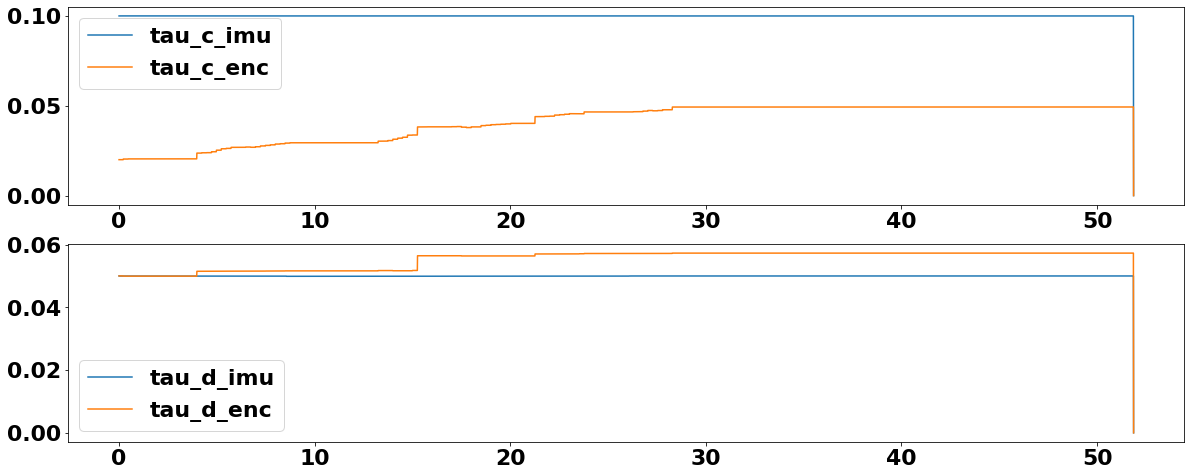

In [12]:
plt.figure(2, figsize=(20,8))
plt.subplot(211)
plt.plot(time_arr, tau_arr_imu[:,0], c='tab:blue', label='tau_c_imu')
plt.plot(time_arr, tau_arr_enc[:,0], c='tab:orange', label='tau_c_enc')
plt.legend()

plt.figure(2, figsize=(20,8))
plt.subplot(212)
plt.plot(time_arr, tau_arr_imu[:,1], c='tab:blue', label='tau_d_imu')
plt.plot(time_arr, tau_arr_enc[:,1], c='tab:orange', label='tau_d_enc')
plt.legend()

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


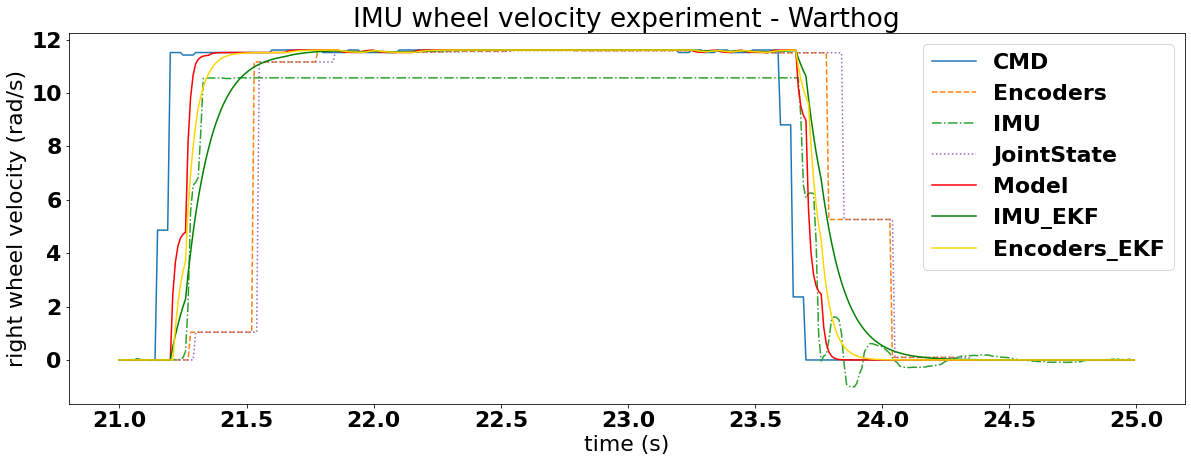

In [13]:
# plot commanded and measured wheel velocities
# slice_start = 400
# slice_end = 800

plt.figure(2, figsize=(20,15))
plt.subplot(211)
plt.plot(time_arr[slice_start:slice_end], left_vel_cmd_arr[slice_start:slice_end], c='tab:blue', label='CMD')
plt.plot(time_arr[slice_start:slice_end], left_vel_meas_arr[slice_start:slice_end], c='tab:orange', linestyle='dashed', label='Encoders')
plt.plot(time_arr[slice_start:slice_end], imu_arr[slice_start:slice_end], c='tab:green', linestyle='dashdot', label='IMU')
plt.plot(time_arr[slice_start:slice_end], left_vel_js_arr[slice_start:slice_end], c='tab:purple', linestyle='dotted', label='JointState')
plt.plot(time_arr[slice_start:slice_end], left_model_vel[slice_start:slice_end], c='red', linestyle='solid', label='Model')
plt.plot(time_arr[slice_start:slice_end], left_EKF_mod_vel_imu[slice_start:slice_end], c='green', linestyle='solid', label='IMU_EKF')
plt.plot(time_arr[slice_start:slice_end], left_EKF_mod_vel[slice_start:slice_end], c='gold', linestyle='solid', label='Encoders_EKF')
plt.xlabel('time (s)')
plt.ylabel('right wheel velocity (rad/s)')
plt.title('IMU wheel velocity experiment - Warthog')
plt.legend()

plt.show()